# Visión por Computador - Práctica 1 - Filtrado de Imágenes

#### 10 puntos   |   Fecha de entrega: 22 de Octubre, 23:59   |   Forma de entrega: a través de la tarea creada en https://pradogrado2324.ugr.es/

### Estudiante: <mark>ALEJANDRO NIETO ALARCÓN</mark>





---



## Normas de entrega

Para este trabajo, al igual que para los demás, se debe presentar código, resultados, discusión de los mismos, y presentación y análisis del trabajo realizado, todo integrado en este mismo Google Colab Notebook. Se recuerda que código y resultados sin informe explicativo no puntúa.

Este trabajo de implementación tiene como objetivo principal familiarizarse con la implementación y uso de filtros de convolución, así como del cálculo de las derivadas de una imagen y sus posibles aplicaciones.

El diseño de celdas del documento debe ser respetado.

Solo se entregará el código fuente (fichero .ipynb incorporando código, resultados, y explicación del trabajo realizado y los resultados obtenidos) y no se enviarán las imágenes empleadas.

El path para la lectura de imágenes, o cualquier otro fichero de entrada, debe ser siempre “/content/drive/My Drive/images/nombre_fichero”

El código deberá  presentarse con los resultados obtenidos en cada apartado junto con los  correspondientes comentarios y valoraciones. De nuevo, recuerde que la entrega de código sin informe explicativo o valoraciones no puntúa.



---



## Funciones de apoyo y conexión con Google Drive

In [ ]:
# We start by getting access to the drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# We import the modules to use
import os,sys
import cv2, numpy as np, math
from matplotlib import pyplot as plt
# change directory
%cd '/content/drive/My Drive'
#  the current directory
%pwd

# This allows to display images  and to save  them in cells
%matplotlib inline
# this definition allows to read files in a specific path
get_image = lambda route: os.path.join('/content/drive/My Drive/images', route)

/content/drive/My Drive


In [ ]:
'''
This function receives a string with the filename of the image to read,
and a flag indicating if we want to read it in color/RGB (flagColor=1) or gray level (flagColor=0)

Example of use:
im1=readIm(get_image('apple.jpg'),0)

'''
def readIm(filename, flagColor=1):
  # cv2 reads BGR format
  im=cv2.imread(filename)
  # change to  RGB and return the image
  if(flagColor):
    return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
  # change from BGR to grayscale instead if flag is 0
  return cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)

In [ ]:
'''
This function receives an array of arbitrary real numbers (that could include even negative values),
and returns an 'image' in the range [0,1].
flag_GLOBAL allows the user to normalize the whole image (including all channels) or to normalize
each channel/band independently.
'''
def rangeDisplay01(im, flag_GLOBAL= True):
  im = im.astype(float)
  if flag_GLOBAL:
    im = (im - im.min())/(im.max() - im.min())
  else:
    # bands normalization
    for band in range(im.shape[2]):
      im[:, :, band] = (im[:, :, band] - im[:, :, band].min())/(im[:, :, band].max() - im[:, :, band].min())
      # Note: remember that, for plt.imshow with RGB data, the valid range is [0..1] for floats and [0..255] for integers.
  return im

In [ ]:
'''
This function displays a single image, including a title, using a magnification factor.

Example of use:
im1=readIm(get_image('apple.jpg'),0)
displayIm(im1,'Manzana',0.5)

'''
def displayIm(im, title='Result',factor= 2):
  # First normalize range
  max=np.max(im)
  min=np.min(im)
  if min<0 or max>255:
    im=rangeDisplay01(im,flag_GLOBAL=True)
  if len(im.shape) == 3:
    # im has three-channels
    plt.imshow(im, cmap='jet')
  else:
    # im has a single-channel
    plt.imshow(im, cmap='gray')
  figure_size = plt.gcf().get_size_inches()
  plt.gcf().set_size_inches(factor * figure_size)
  plt.title(title)
  plt.xticks([]), plt.yticks([])
  plt.show()

In [ ]:
'''
This function displays multiple images (including a title and using a magnification factor)
of equal size. The input to the function is a list of images.

Example of use:
im1=readIm(get_image('apple.jpg'),1)
images = [im1,im1,im1]

displayMI_ES(images, title='Manzanas',factor=1)

'''
def displayMI_ES(vim, title='Result',factor=2):
  # We set the maximun number of images to concatenate by columns
  maxcolumns=3
  # number of images to display
  numberim=len(vim)
  # The simplest case, one row: the maximum number of columns is larger than the images to stack
  # This is, by default, we put together the images column-wise
  if len(vim) < maxcolumns:
    out=vim[0]
    for item in range(1,len(vim)):
      #displayIm(out,str(item),1)
      out=np.hstack((out,vim[item]))

  # Else, if maxcolumns is smaller or equal than the number of images to stack
  else:
    # We check if all rows and columns are going to be 'busy', or if otherwise we need an extra-row
    if np.mod(len(vim),maxcolumns)== 0:
      maxrows=numberim//maxcolumns
    else:
      maxrows=numberim//maxcolumns+1

    # we build up the first block-row
    out=vim[0]
    for item in range(1,maxcolumns):
      out=np.hstack((out,vim[item]))
    # We build up the rest of block-rows
    for block in range(1,maxrows):
      #print(block)
      row=vim[block*maxcolumns]
      for item in range(1,maxcolumns):
        # We still have images to stack
        if block*maxcolumns+item < numberim:
          row=np.hstack((row,vim[block*maxcolumns+item]))
        # We do not have more images, and we have to fill with black
        else:
          row=np.hstack((row,np.zeros(vim[0].shape,dtype=vim[0].dtype)))
          #print(row.dtype)
          # if we don't include ',dtype=vim[0].dtype', np.zeros will include float
          # numbers in the matrix. This will make that the whole matrix will be
          # considered as floats, and values larger than 1 will be clipped to 1,
          # displaying an almost totally white image
      # add the new block-row
      out=np.vstack((out,row))
  return displayIm(out,title,factor)

# **Ejercicio 1: discretización de máscaras y filtrado Gaussiano** (4 puntos).

En este ejercicio aprenderemos a discretizar máscaras de convolución y a aplicarlas sobre imágenes empleando funciones de OpenCV. También buscamos hacerlo de un modo eficiente, y es por ello que, en toda la práctica, se exige el uso de convoluciones 1D (separables).

El documento pdf sobre Gaussian discretization disponible en PRADO (https://pradogrado2324.ugr.es/pluginfile.php/178298/mod_folder/content/0/Material%20de%20Apoyo/Gaussian_discretization.pdf) puede resultar de gran utilidad para la implementación del primer ejercicio.




## A) (1.5 puntos)

Calcule las máscaras discretas 1D de la Gaussiana y tanto su primera como segunda derivadas (normalizadas). Considere que la entrada a dicha función de creación de máscaras 1D puede ser tanto un posible sigma como un posible tamaño de máscara. Emplee los siguientes valores de sigma ($\{1, 2.5, 5\}$) y los siguientes valores de tamaño de máscara ($\{5, 9, 15\}$), y muestre el perfil (es decir, la silueta de las máscaras como funciones 1D) para verificar que las máscaras creadas son correctas.

En este primer punto lo que hacemos es expresar a través de funciones la Gaussiana y su derivada primera y segunda.

Para representar la Gaussiana lo que hacemos es eliminar la parte que normaliza ya que no nos hará falta.

Derivada primera derivamos la funcion Gaussiana

Derivada segunda derivamos la funcion resultante de la primera derivada.

Estas funciones anteriores serán los distintos kernels que iremos aplicando a lo largo de la práctica.

Por último en este apartado calculamos la máscara 1D a partir del sigma, el tamaño de máscara y el orden. Es fácilmente calculable la máscara a través del sigma o el tamaño de la máscara a través de las fórmulas que se nos muestran en las transparencias de prácticas aunque debemos tener en cuenta ciertos detalles para realizar bien la máscara según su orden. En primer lugar para orden 0 debemos tener en cuenta que la suma de los valores de la máscara han de sumar 1 por lo cual debemos normalizar los datos de esta dividiendo cada uno de los valores de la máscara entre la suma de todos los valores de la máscara.
Las derivadas debemos multiplicarlas por sigma y sigma cuadrado respectivamente para hacerlo de forma correcta

In [ ]:
def GaussFunc(x,sigma):
    return np.exp(-1*x**2/(2*sigma**2))

def GaussDeriv1Func(x,sigma):
    return -x/(sigma**2)*GaussFunc(x,sigma)

def GaussDeriv2Func(x,sigma):
    return (x**2/sigma**4 - 1/sigma**2)*GaussFunc(x,sigma)

def gaussianMask1D(sigma=0, sizeMask=0, order=0):

    if sigma != 0 and sizeMask == 0:
      sizeMask = int(2 * 3 * sigma + 1)
    if sigma == 0 and sizeMask != 0:
      sigma = (sizeMask - 1) / (2*3)

    k = ((sizeMask - 1) / 2)

    if order == 0:
      mask = GaussFunc(np.linspace(-k,k,sizeMask), sigma)
      mask = mask / mask.sum()

    elif order == 1:
      mask = GaussDeriv1Func(np.linspace(-k,k,sizeMask), sigma)
      mask = mask * (sigma)
    elif order == 2:
      mask = GaussDeriv2Func(np.linspace(-k,k,sizeMask), sigma)
      mask = mask * (sigma**2)

    return mask

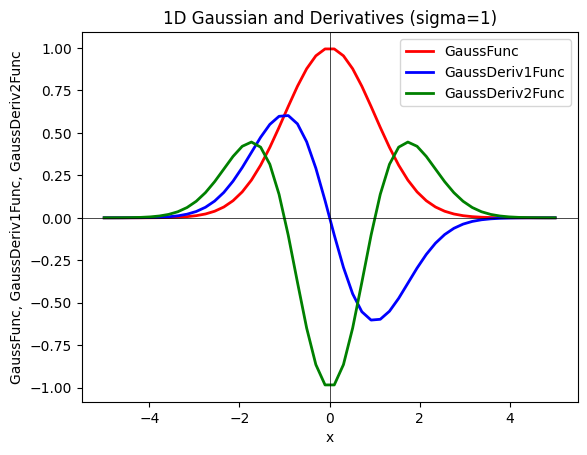

In [ ]:
# Con la siguiente figura verificamos que las funciones Gaussianas implementadas son correctas
plt.figure()
xvalues = np.linspace(-5, 5)
yvalues1 = GaussFunc(xvalues,1)
yvalues2 = GaussDeriv1Func(xvalues,1)
yvalues3 = GaussDeriv2Func(xvalues,1)
plt.plot(xvalues, yvalues1, lw=2, color='red',
label='GaussFunc')
plt.plot(xvalues, yvalues2, lw=2, color='blue',
label='GaussDeriv1Func')
plt.plot(xvalues, yvalues3, lw=2, color='green',
label='GaussDeriv2Func')
plt.title('1D Gaussian and Derivatives (sigma=1)')
plt.xlabel('x')
plt.ylabel('GaussFunc, GaussDeriv1Func, GaussDeriv2Func')
plt.axhline(0, lw=0.5, color='black')
plt.axvline(0, lw=0.5, color='black')
plt.legend()

En este punto lo que he realizado es finalizar los bucles con el correcto uso de los gráficos donde en el primer bucle fijamos el tamaño de la máscara mientras que en el segundo bucle fijamos el valor del sigma. Podemos ver que conforme vamos aumentando sigma y tamaño de máscara los gráficos se van suavizando. Esto es debido a que cuanto más grande es la máscara más valores tenemos que representan a la función por lo que estará cada vez mejor representada.

En este punto también realicé la correcta comprobación de la máscara de suavizado y la máscara de diferenciación haciendo coincidir las graficas con las de la plantilla y viendo que los valores de salida para cada una de las máscaras fuese correcto

FIJAMOS PRIMERO EL TAMAÑO DE LA MÁSCARA


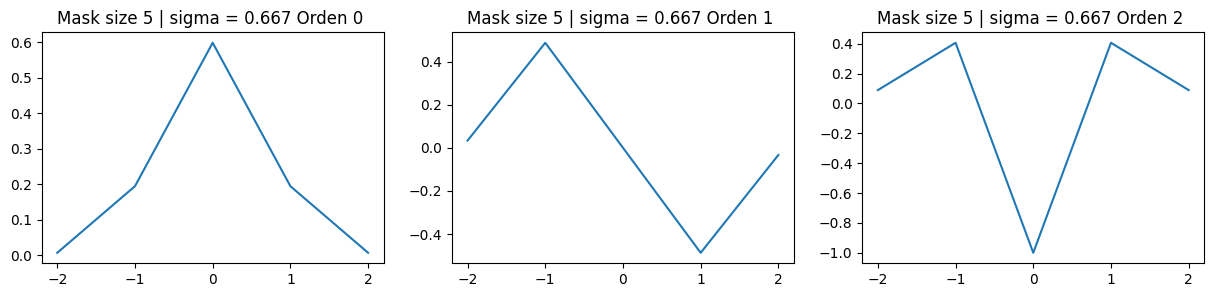

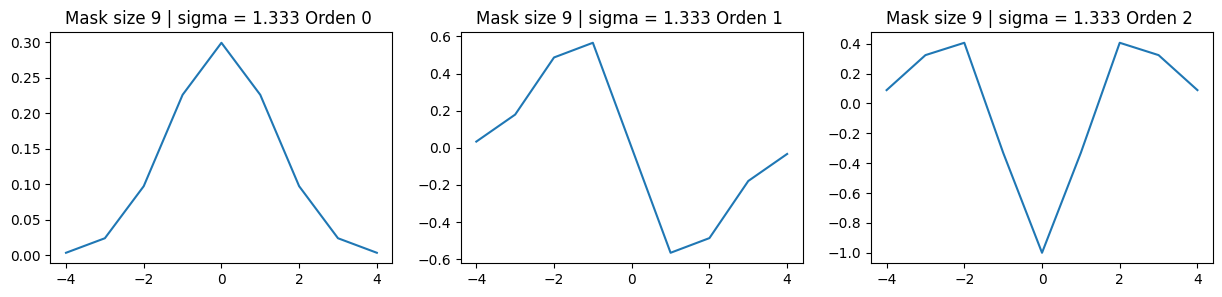

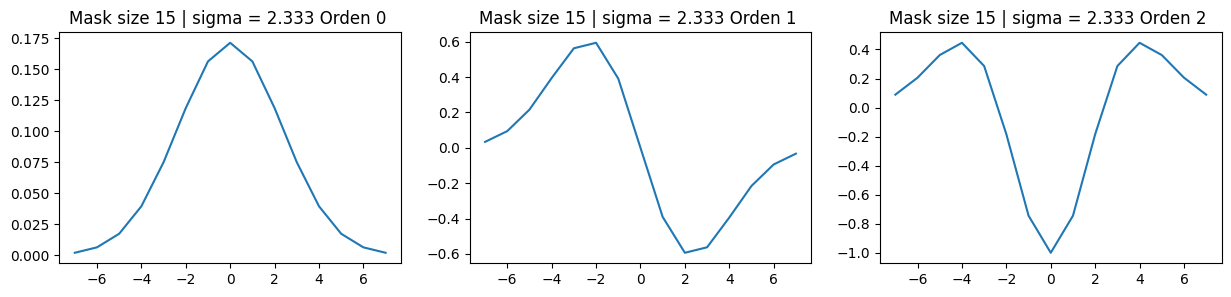

FIJAMOS AHORA EL SIGMA


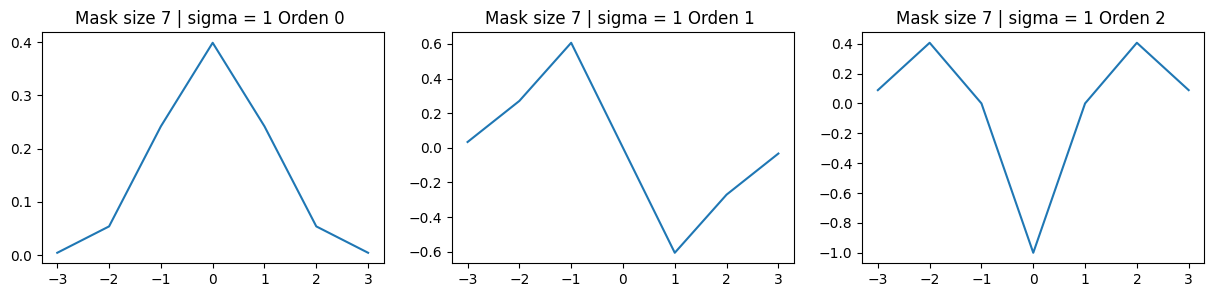

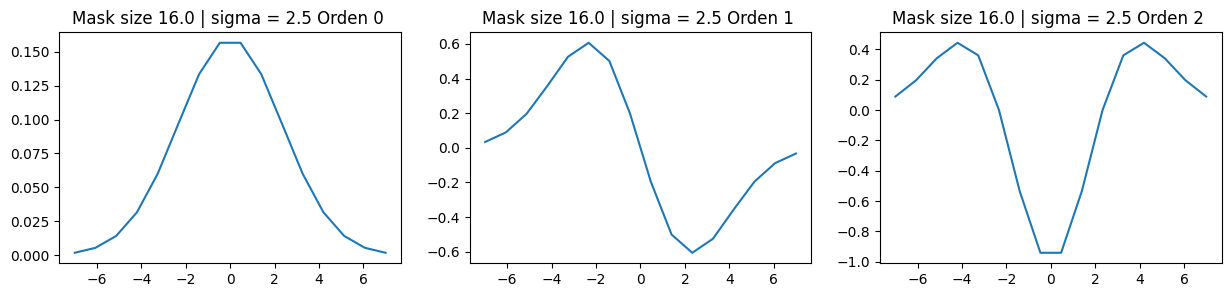

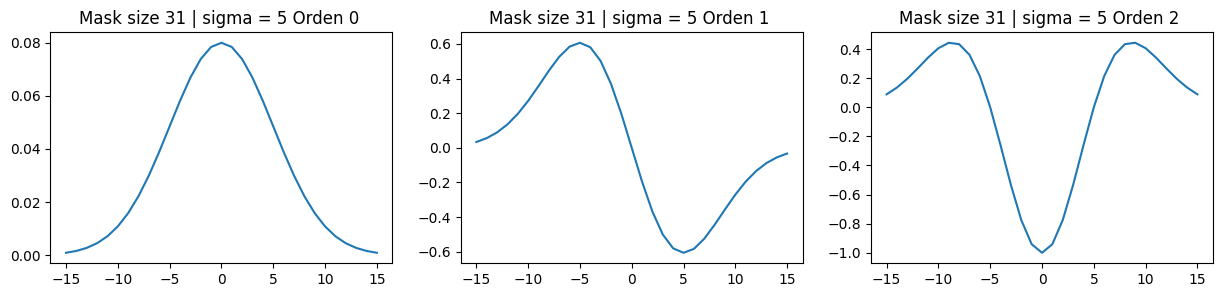

In [ ]:
sigma_values = [1, 2.5, 5]
size_masks = [5,9,15]

plt.rcParams["figure.figsize"] = (15,3) # para ajustar tamaño del ancho y alto (ejes)
print('FIJAMOS PRIMERO EL TAMAÑO DE LA MÁSCARA')
for sizeMask in size_masks:

    xvalues = np.linspace(-((sizeMask - 1) / 2),((sizeMask - 1) / 2),sizeMask)

    #yvalues = GaussFunc(xvalues, )
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

    ax1.title.set_text("Mask size " + str(sizeMask) + " | sigma = " + str(round((sizeMask-1)/6, 3)) + " Orden 0 " )
    ax1.plot(xvalues, gaussianMask1D(sizeMask = sizeMask, order = 0))

    ax2.title.set_text("Mask size " + str(sizeMask) + " | sigma = " + str(round((sizeMask-1)/6, 3)) + " Orden 1 " )
    ax2.plot(xvalues,  gaussianMask1D(sizeMask = sizeMask, order = 1))

    ax3.title.set_text("Mask size " + str(sizeMask) + " | sigma = " + str(round((sizeMask-1)/6, 3)) + " Orden 2 " )
    ax3.plot(xvalues,  gaussianMask1D(sizeMask = sizeMask, order = 2))

    plt.show()

print('FIJAMOS AHORA EL SIGMA')
for sigma in sigma_values:


    xvalues = np.linspace(-int(((1+sigma*2*3 - 1) / 2)),int(((1+sigma*2*3 - 1) / 2)),int(1+sigma*2*3))

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

    ax1.title.set_text("Mask size " + str(1+sigma*2*3) + " | sigma = " + str(sigma) + " Orden 0 " )
    ax1.plot(xvalues, gaussianMask1D(sigma = sigma, order = 0))

    ax2.title.set_text("Mask size " + str(1+sigma*2*3) + " | sigma = " + str(sigma) + " Orden 1 " )
    ax2.plot(xvalues,  gaussianMask1D(sigma = sigma, order = 1))

    ax3.title.set_text("Mask size " + str(1+sigma*2*3) + " | sigma = " + str(sigma) + " Orden 2 " )
    ax3.plot(xvalues,  gaussianMask1D(sigma = sigma, order = 2))


    plt.show()



## B) (1.5 puntos)

Lea una imagen en escala de grises y fíltrela mostrando el resultado de la convolución con una Gaussiana, con la primera derivada de la Gaussiana (tanto en X como en Y), y con la segunda derivada de la Gaussiana (tanto en X como en Y). Emplee los siguientes sigmas: $\{0.75,2,5,10,15\}$. Muestra todas las imágenes dentro del mismo canvas, tal y como se muestra más abajo. En este apartado, se debe usar la función de OpenCV `sepFilter2D()` con las máscaras calculadas con las funciones desarrolladas en el apartado anterior.




A continuación lo que haremos será aplicar una convolución Gaussiana a una imagen en escala de grises y lo que haremos será ir aumentando el sigma para ver como cada vez se va suavizando más la imagen y también realizaremos el proceso para la primera y segunda derivada tanto en X como en Y.
El resultado de la primera imagen que esta en orden [0,0] podemos ver que la imagen mantiene el mismo color que la original pero cada vez se va difuminando más quedandonos así solo con bajas frecuencias cada vez y haciendo indistinguible lo que hay en la imagen si aumentasemos aún más el sigma aunque no llegamos a ese punto en este caso.

La segunda imagen que tenemos es la que tenemos de orden [0,1] en la que aplicamos la primera derivada en Y y como podemos ver no tiene el mismo color que la imagen original y se puede ver claramente un suavizado cada vez mayor en el que podemos ver que tiende a enfatizar lineas horizontales que toman cada vez mayor presencia con el aumento del sigma.

La tercera imagen que tenemos es la que tenemos de orden [1,0] en la que aplicamos la primera derivada en X y como podemos ver no tiene el mismo color que la imagen original pero que se asemeja a la segunda y se puede ver claramente un suavizado cada vez mayor en el que podemos ver que tiende a enfatizar lineas verticales.

Para la cuarta y quinta imagenes en las que aplicamos el orden [0,2] y [2,0] son muy parecidas a las segunda y tercera respectivamente pero con un mayor desenfoque devido a que aplicamos la segunda derivada

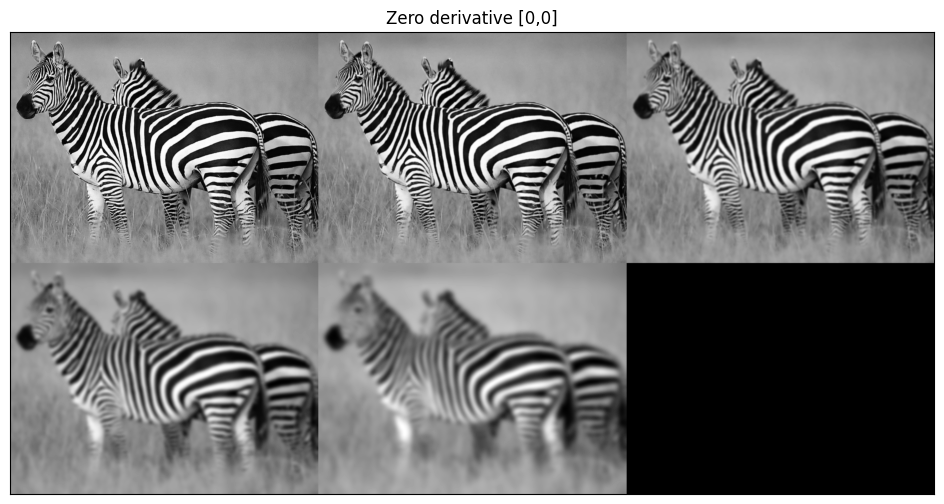

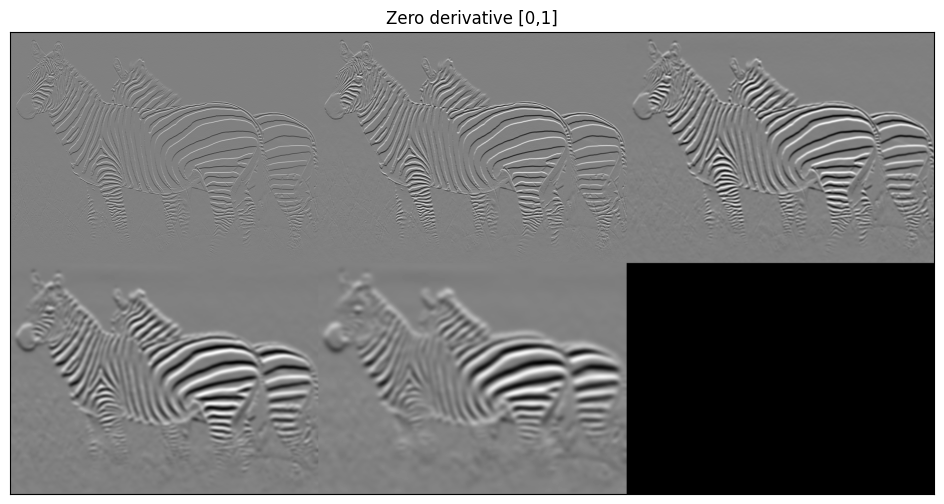

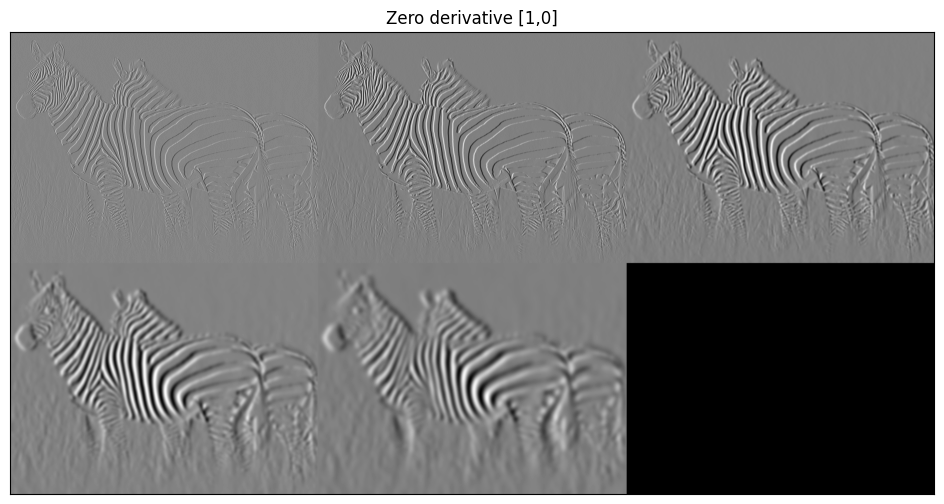

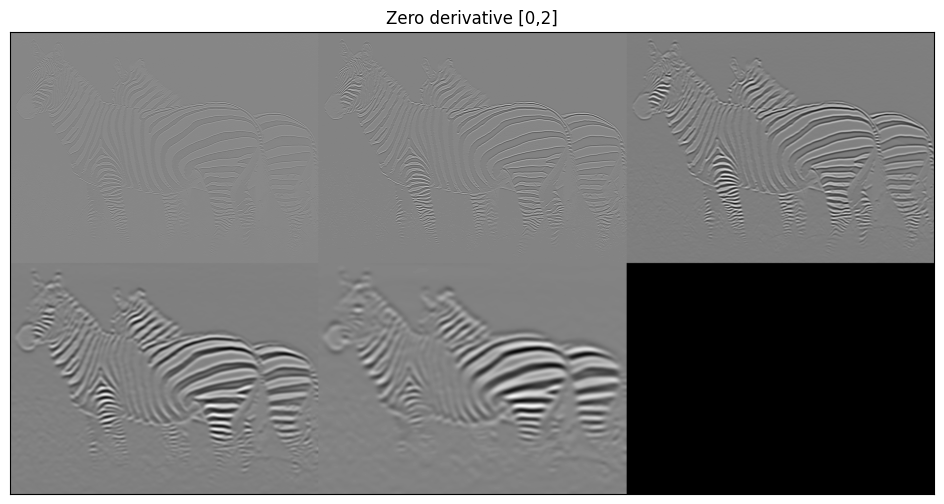

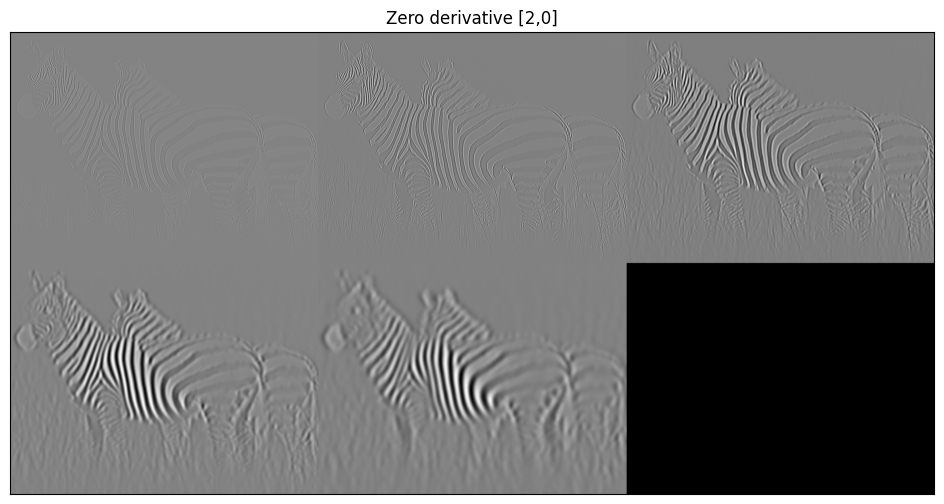

In [ ]:
def my2DConv(im, sigma, orders):
  ddepth=cv2.CV_64F

  maskG=gaussianMask1D(sigma=sigma, order=0)
  maskDG=gaussianMask1D(sigma=sigma, order=1)
  mask2DG= gaussianMask1D(sigma=sigma, order=2)

  if orders==[0,0]: # Suavizado Gaussiano
    return cv2.sepFilter2D(im,ddepth,maskG,maskG)

  elif orders!=[0,0]:

    if orders==[0,1]:
      return cv2.sepFilter2D(im,ddepth,maskG,maskDG)
    elif orders==[0,2]:
      return cv2.sepFilter2D(im,ddepth,maskG,mask2DG)
    elif orders==[1,0]:
      return cv2.sepFilter2D(im,ddepth,maskDG,maskG)
    elif orders==[2,0]:
      return cv2.sepFilter2D(im,ddepth,mask2DG,maskG)

  else:
    print('error in order of derivative')

# let's check the function
im=cv2.imread(get_image('zebra.jpg'),0)
vim0=[]
vim1=[]
vim2=[]
vim3=[]
vim4=[]
orders=[0,0]
for sigma in [0.75,2,5,10,15]:
  vim0.append(rangeDisplay01(my2DConv(im,sigma,orders),True))
  vim1.append(rangeDisplay01(my2DConv(im,sigma,[0,1]),True))
  vim2.append(rangeDisplay01(my2DConv(im,sigma,[0,2]),True))
  vim3.append(rangeDisplay01(my2DConv(im,sigma,[1,0]),True))
  vim4.append(rangeDisplay01(my2DConv(im,sigma,[2,0]),True))

displayMI_ES(vim0,'Zero derivative [0,0]',2)
displayMI_ES(vim1,'Zero derivative [0,1]',2)
displayMI_ES(vim3,'Zero derivative [1,0]',2)
displayMI_ES(vim2,'Zero derivative [0,2]',2)
displayMI_ES(vim4,'Zero derivative [2,0]',2)




## C) (1 punto)

Emplee la función de OpenCV `sepFilter2D()` y $\sigma=3.0$ para calcular el gradiente (4 imágenes: derivada en X, derivada en Y, magnitud y orientación) y la Laplaciana de la Gaussiana.

En este apartado vamos a realizar las imagenes que nos piden con el sigma dicho.

La primera imagen de salida es la imagen suavizada de orden [1,0] por que hemos aplicado la primera derivada en el eje X y como hemos dicho antes podemos ver que claramente tiende a enfatizar lineas verticales.

La segunda imagen de salida es la imagen suavizada de orden [0,1] porque hemos aplicado la primera derivada en el eje Y y como mencionamos en anteriores apartados se tiende a enfatizar lineas horizontales.

La tercera imagen es la magnitud del gradiente calculada a través de la siguiente formula $\sqrt{G_x^2 + G_y^2}$ siendo $G_x$ la primera imagen de salida y $G_y$ la segunda imagen se salida de este apartado. En esta imagen podemos ver que hay un alto contraste para los bordes viendo de forma muy clara cada uno de los bordes de las manchas de la cebra.

La cuarta imagen es la orientación del gradiente calculada a través de a siguiente fórmula $atan2(G_y, G_x)$ siendo $G_x$ la primera imagen de salida y $G_y$ la segunda imagen se salida de este apartado.

La quinta imagen es la Laplaciana de la imagen que se calcula a través de la suma de la derivada segunda en X y de la derivada segunda en Y dando lugar a una imagen con un color grisaceo en el que se pueden ver de una forma muy clara los bordes.


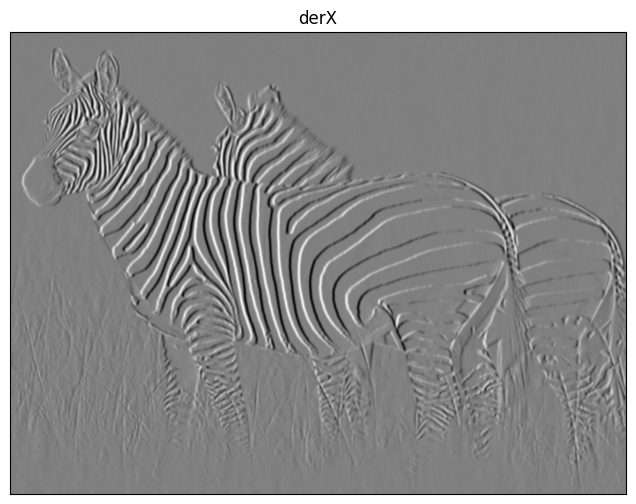

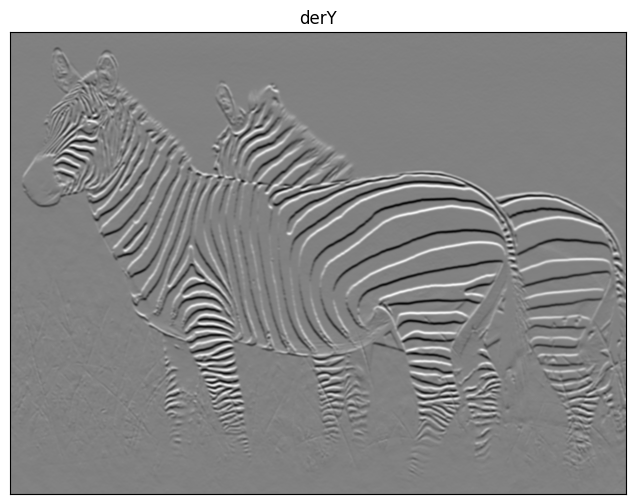

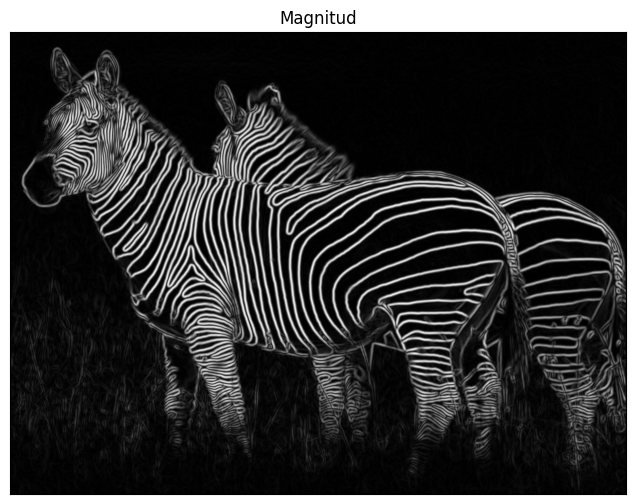

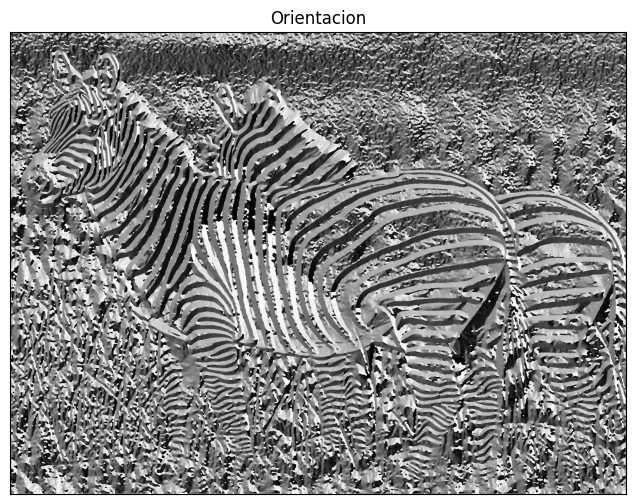

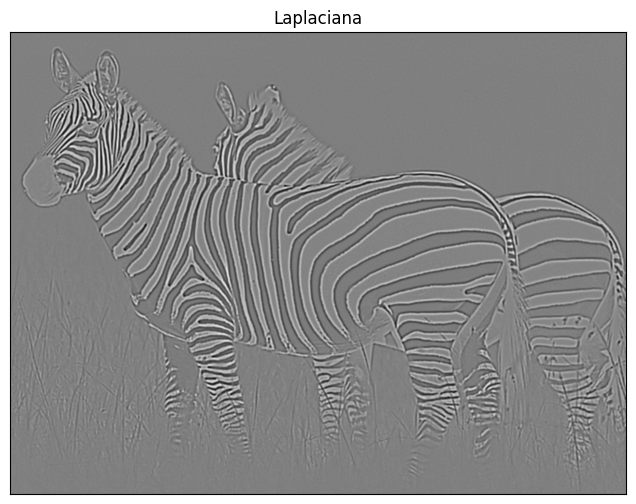

In [ ]:
sigma = 3.0

vim0=[]
vim0.append(rangeDisplay01(my2DConv(im,sigma,[1,0]),True))
displayMI_ES(vim0,'derX',2)

vim1=[]
vim1.append(rangeDisplay01(my2DConv(im,sigma,[0,1]),True))
displayMI_ES(vim1,'derY',2)

vim2=[]
vim2.append(np.sqrt(np.power(my2DConv(im,sigma,[1,0]),2) + np.power(my2DConv(im,sigma,[0,1]),2)))
displayMI_ES(vim2,'Magnitud',2)

vim4=[]
vim4.append(np.arctan2(my2DConv(im,sigma,[0,1]), my2DConv(im,sigma,[1,0])))
displayMI_ES(vim4,'Orientacion',2)

vim3=[]
vim3.append( (my2DConv(im,sigma,[2,0]) +  my2DConv(im,sigma,[0,2])))
displayMI_ES(vim3,'Laplaciana',2)

# **Ejercicio 2**:  Pirámides Gaussianas y Laplacianas (3 points)







## A) (1.5 puntos)

Construya una pirámide Gaussiana de 4 niveles empleando máscaras Gaussianas de tamaño 7x7. No se permite emplear las funciones `pyrUp()` y `pyrDown()` de OpenCV.

In [ ]:
'''
This function displays a pyramid of images, providing as input the list of images to display.

Example of use:
im1=readIm(get_image('apple.jpg'),1)
images = [im1, cv2.resize(im1,(im1.shape[0]//2,im1.shape[1]//2),cv2.INTER_LINEAR), cv2.resize(im1,(im1.shape[0]//4,im1.shape[1]//4),cv2.INTER_LINEAR), cv2.resize(im1,(im1.shape[0]//8,im1.shape[1]//8),cv2.INTER_LINEAR), cv2.resize(im1,(im1.shape[0]//16,im1.shape[1]//16),cv2.INTER_LINEAR)]

displayPyramid(images, title='Piramide de Manzanas')

'''
def displayPyramid(vim, title='result'):
  temp = np.zeros_like(vim[0])
  if np.mod(temp.shape[1],2)==0:
    h = temp[:, :temp.shape[1]//2]
  else:
    h = temp[:, :(temp.shape[1]//2)+1]
  out = np.hstack((temp, h))
  top = 0
  out[0:vim[0].shape[0], 0:vim[0].shape[1]] = vim[0]
  left = vim[0].shape[1]
  for i in range(1, len(vim)):
    out[top:top+vim[i].shape[0], left:left + vim[i].shape[1]] = vim[i]
    top += vim[i].shape[0]
  displayIm(out, title)

En este ejercicio básicamente lo que se hace es hacer un bucle en el cual suavizamos la imagen que se nos da de entrada y reducimos su tamaño a la mitad realizando una interpolación lineal. Esto con el objetivo de disminuir las dimensiones de la imagen de entrada mientras se conserva la información visual tanto como sea posible. La interpolación lineal implica calcular nuevos valores de píxeles intermedios a partir de los píxeles originales de la imagen.

De esta forma obtenemos la pirámide de Gauss

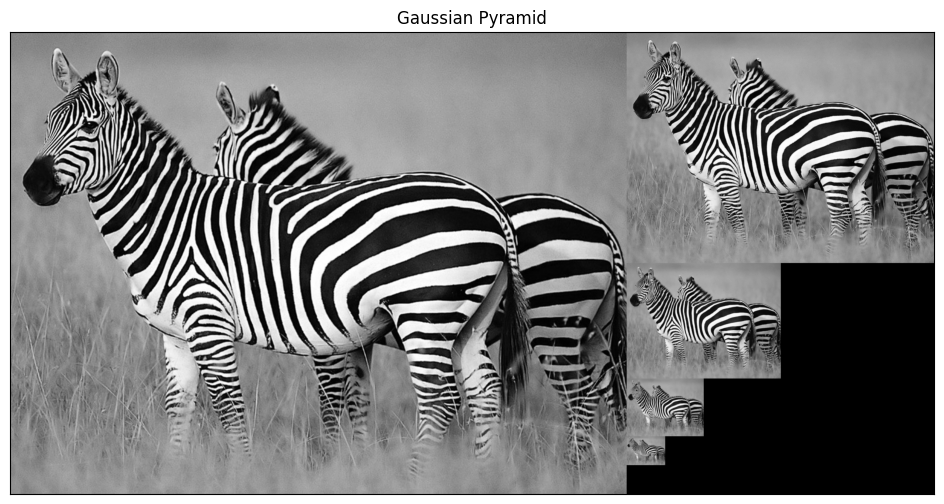

In [ ]:
def pyramidGauss(im,sizeMask=7, nlevel=4):
  vim=[im]
  sigma = (sizeMask - 1) / (2*3)

  for i in range(nlevel):
    im_suavizada = my2DConv(vim[i],sigma,[0,0])
    vim.append(cv2.resize(im_suavizada,(im_suavizada.shape[1]//2,im_suavizada.shape[0]//2),cv2.INTER_LINEAR))

  return vim

im=cv2.imread(get_image('zebra.jpg'),0)
pyrG = pyramidGauss(im,sizeMask=7, nlevel=4)
displayPyramid(pyrG,'Gaussian Pyramid')


## B) (1 punto)

Use su código del apartado anterior para implementar una función que permita construir una pirámide Laplaciana de 4 niveles.

Para reconstruir la pirámide Laplaciana necesitamos la pirámide de Gauss y a partir de ella para la primera imagen lo que necesitamos es la primera imagen de la pirámide Laplaciana será el resultado de la primera imagen de la pirámide de Gauss restandole los valores de la siguiente imagen en la pirámide de Gauss (obviamente tenemos que realizar un aumento de la segunda imagen para que tenga el mismo tamaño de la primera y de esta forma poder restarlo). También es importante que para construir esta pirámide Laplaciana es necesario usar la misma interpolación usada a la hora de crear la pirámide de Gauss, que en este caso es la interpolación lineal. Una vez hagamos el proceso anterior para cada una de las imágenes llegaremos a la imagen final de la piramide de Gauss que no tiene siguiente para restar por lo cual la añadimos tal cual a la pirámide Laplaciana.

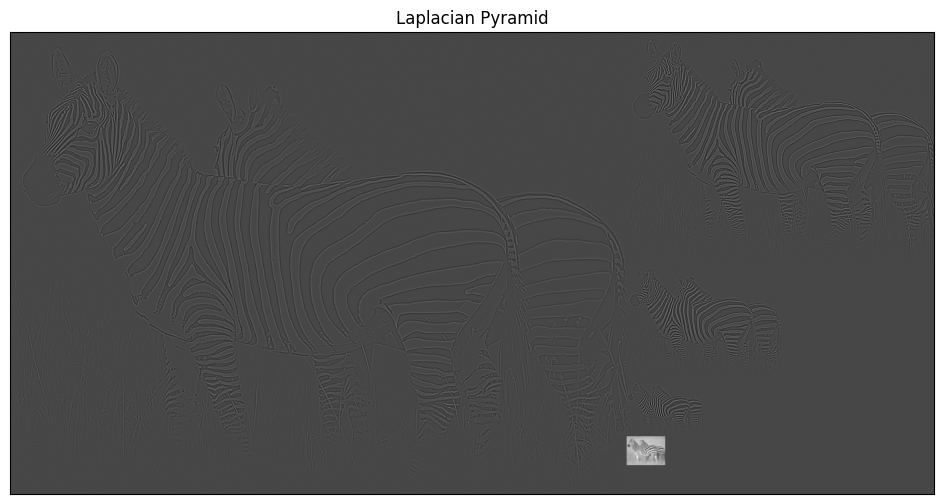

In [ ]:
def pyramidLap(im, sizeMask,nlevel=4,flagInterp=cv2.INTER_LINEAR  ):
  vim=pyrG=pyramidGauss(im,sizeMask=sizeMask, nlevel=nlevel)
  vimL=[]

  for i in range(len(vim) - 1):
    vimL.append(vim[i] - cv2.resize(vim[i+1],(vim[i].shape[1],vim[i].shape[0]), flagInterp))

  vimL.append(vim[len(vim) - 1])

  return vimL

im=cv2.imread(get_image('zebra.jpg'),0)
pyrL = pyramidLap(im,sizeMask=7, nlevel=4)
displayPyramid(pyrL,'Laplacian Pyramid')

## C) (0.5 puntos)

Implemente ahora una función para reconstruir la imagen codificada en la pirámide Laplaciana. Verifique que es posible obtener una copia exacta de la imagen original. Para ello, calcule el error de reconstrucción como la norma Euclídea de las diferencias entre los niveles de intensidad de la imagen original y la imagen reconstruida.

Para realizar la reconstruccion de la imagen a partir de la pirámide Laplaciana lo que debemos hacer es empezar por lo imagen del final e ir realizando la siguiente operación. Empezamos por la imagen final de la pirámide Laplaciana y le hacemos un resize al tamaño de la imagen anterior y la sumamos y con esta nueva imagen repetimos el proceso para la imagen anterior hasta que lleguemos al final. (Es un proceso inverso al de la pirámide Laplaciana)

La propiedad clave que hace posible recuperar la imagen original a partir de su pirámide Laplaciana es que la información perdida durante el proceso de submuestreo y suavizado se almacena en cada uno de los niveles. Esto significa que si tienes todos los niveles de detalle y la versión suavizada más baja de la pirámide, puedes reconstruir la imagen original.

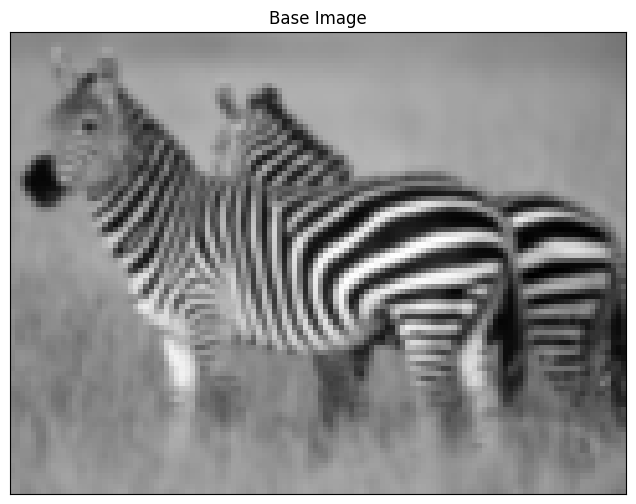

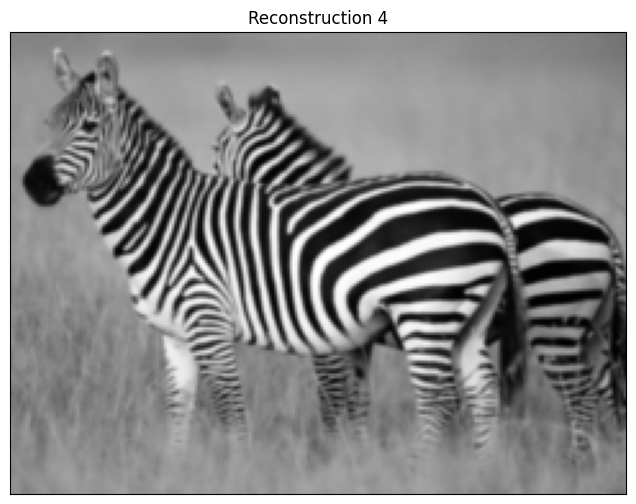

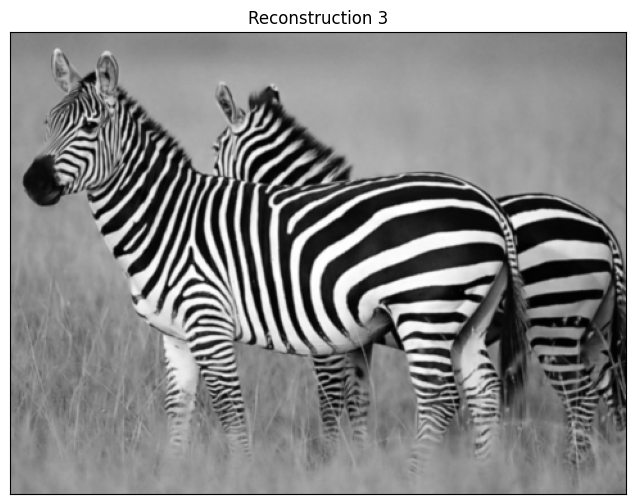

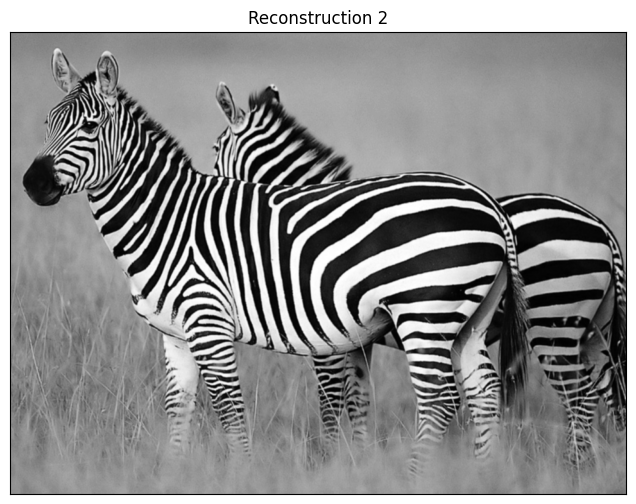

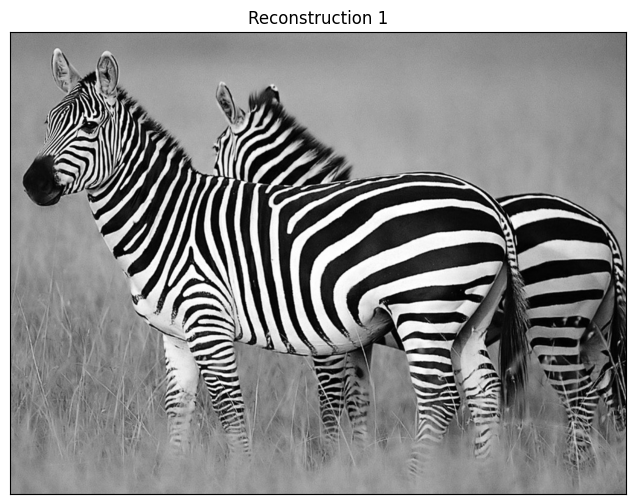

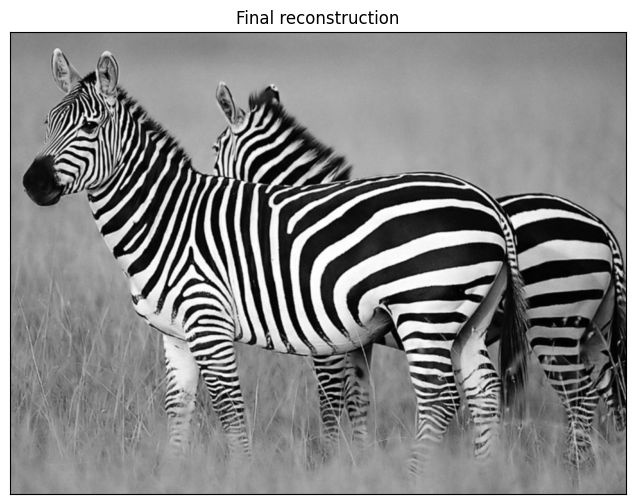

Error per pixel 0.0


In [ ]:
def reconstructLap(pyL,flagInterp, outputs=True):

  if outputs == True:
    vim=[]
    vim.append(pyL[len(pyL) - 1])
    displayMI_ES(vim,'Base Image',2)

  for i in range(1, len(pyL)):
    pyL[len(pyL) - i - 1] = pyL[len(pyL) - i - 1] + cv2.resize(pyL[len(pyL) - i], (pyL[len(pyL) - i ].shape[1]*2, pyL[len(pyL) - i].shape[0]*2), cv2.INTER_LINEAR)

    if outputs == True:
      vim=[]
      vim.append(pyL[len(pyL) - i - 1])
      displayMI_ES(vim,'Reconstruction ' + str(len(pyL) - i),2)

  if outputs == True:
    vim=[]
    vim.append(pyL[len(pyL) - i])
    displayMI_ES(vim,'Final reconstruction',2)

  return pyL[0]

im=cv2.imread(get_image('zebra.jpg'),0)
pyrL = pyramidLap(im,sizeMask=7, nlevel=4)
recons = reconstructLap(pyrL, cv2.INTER_LINEAR)
print('Error per pixel',np.sqrt(np.linalg.norm(im-np.round(recons), ord=2)/np.prod(im.shape)))

# **Ejercicio 3: Imágenes Híbridas** (2 puntos)

Este ejercicio se basa en el siguiente trabajo: $\textit{Oliva, A., Torralba, A., & Schyns, P. G. (2006). Hybrid images. ACM Transactions on Graphics (TOG), 25(3), 527-532}$. (https://stanford.edu/class/ee367/reading/OlivaTorralb_Hybrid_Siggraph06.pdf).  

El objetivo es aprender cómo el sistema visual humano extrae información sobre un objeto en función de la distancia. Para ello, construimos una imagen híbrida a partir de dos imágenes de objetos diferentes. Mezclando adecuadamente parte de las altas frecuencias de una imagen con parte de las bajas frecuencias de otra imagen, obtenemos una imagen híbrida que muestra diferentes percepciones con la distancia. El sigma empleado para filtrar ambas imágenes (tanto la de alta como la de bajas frecuencias) es el aspecto clave para seleccionar el rango de frecuencias altas y bajas de cada imagen. Cuanto mayor sea el valor sigma, mayor será la eliminación de altas frecuencias de la imagen. Se recomienda elegir este valor por separado para cada una de las imágenes y, de hecho, seguramente sea posible (y deseable) el tener distintos valores para distintos pares de imágenes. Recuerde emplear la pirámide Gaussiana para mostrar el efecto obtenido.

La clave de esto se haya en que cuando realizamos el suavizado de una imagen lo que eliminamos son las altas frecuencias por lo cual si superponemos las altas frecuencias de una imagen sobre las bajas de otra cuando mayor sea el suavizado más desaparecerán las altas frecuencias por eso al realizar la piramide de Gauss de cada una de las imagenes lo que pasa es que al comienzo se ven los rasgos de la imagen con altas frecuencias y conforme el suavizado aumenta estas dejan de verse y se puede apreciar de una mejor forma la imagen de la que obtuvimos las bajas frecuencias.

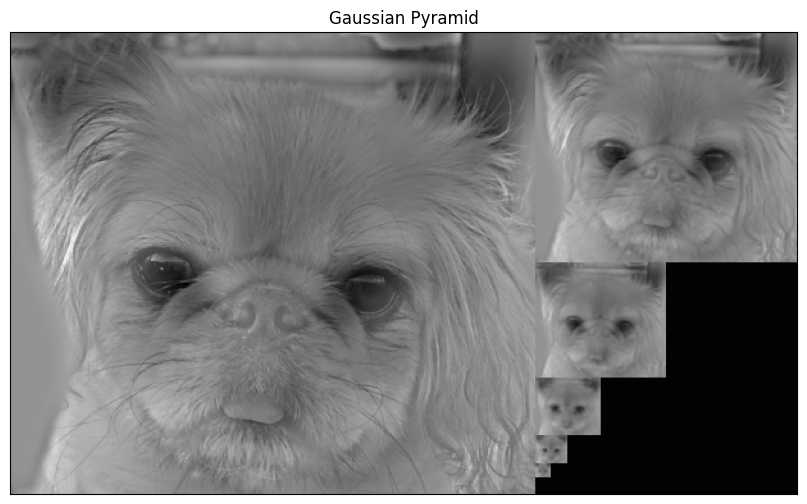

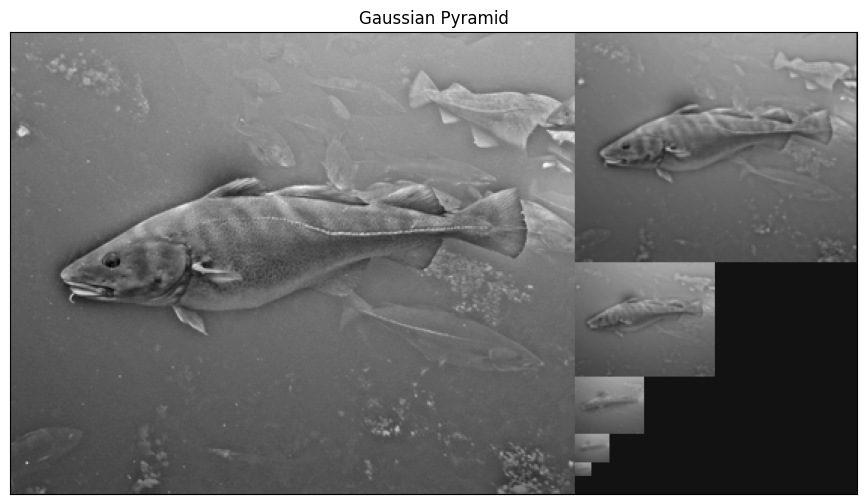

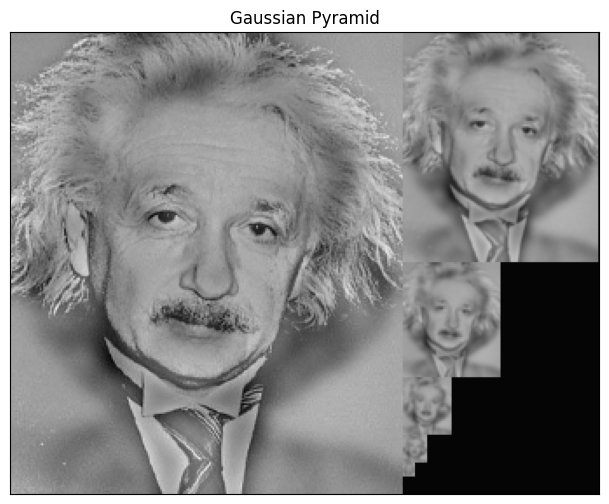

In [ ]:
def hibridar_imagen(im_1, im_2, sigma_1, sigma_2):
  alisado_im_1 = []
  alisado_im_2 = []
  frec_altas_im_1  = []

  alisado_im_2.append(my2DConv(im_2,sigma_2,[0,0]))
  alisado_im_1.append(my2DConv(im_1,sigma_1,[0,0]))
  frec_altas_im_1.append(im_1 - alisado_im_1[0])

  im = alisado_im_2[0] + frec_altas_im_1[0]

  pyrG = pyramidGauss(im,sizeMask=7, nlevel=5)
  return pyrG

im_perro = cv2.imread(get_image('dog.bmp'),0)
im_gato = cv2.imread(get_image('cat.bmp'),0)
pyr_PG = hibridar_imagen(im_perro, im_gato, 6, 10)
displayPyramid(pyr_PG,'Gaussian Pyramid')

im_pez = cv2.imread(get_image('fish.bmp'),0)
im_submarino = cv2.imread(get_image('submarine.bmp'),0)
pyr_PG = hibridar_imagen(im_pez, im_submarino, 5, 10)
displayPyramid(pyr_PG,'Gaussian Pyramid')

im_einstein = cv2.imread(get_image('einstein.bmp'),0)
im_mari = cv2.imread(get_image('marilyn.bmp'),0)
pyr_PG = hibridar_imagen(im_einstein, im_mari, 5, 5)
displayPyramid(pyr_PG,'Gaussian Pyramid')


# **Ejercicio 4: Pyramid Blending** (1 punto)

En este ejercicio se debe crear la imagen fusionada (horizontal) de la manzana (`apple.jpg`) y la naranja (`orange.jpg`) empleando la técnica de $\textit{Pyramid Blending}$. Para este ejercicio, si se desea, sí se pueden emplear las funciones de OpenCV `pyrDown` y `pyrUp`. Para que el ejercicio puntúe, es esencial explicar en detalle el proceso seguido a la hora de crear la nueva imagen (mezcla de ambas). El resultado debe ser similar al mostrado en la celda de resultados correspondiente.  



Pyramid blending es una técnica utilizada para combinar dos imágenes de manera suave y sin costuras. La técnica se basa en el uso de pirámides Gaussianas y pirámides Laplacianas para lograr una transición gradual y natural entre las imágenes que se están fusionando.

Como es una imagen RGB lo que haremos será coger cada uno de los colores de la imagen por separado e ir haciendole la laplaciana a cada uno de los colores y cogeremos la mitad superior de la manzana y la mitad inferior de la naranja.

Una vez hecho lo anterior para los tres colores lo que haremos sera reconstruir la imagen a partir de las pirámides laplacianas y por último volveremos a juntar los tres canales de color para dar el resultado final.

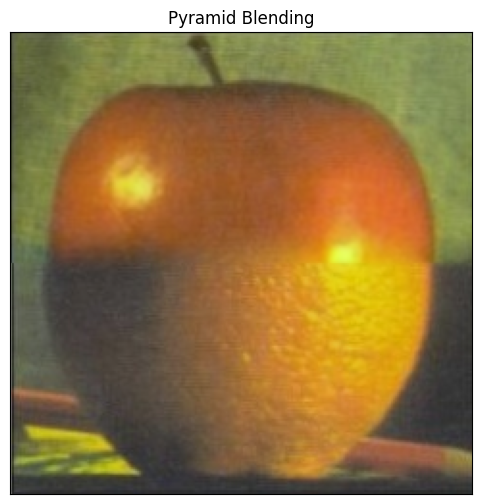

In [ ]:
def get_laplacian_of_colour(O_C, A_C, sizeMaskValue, nlevel = 4):
  pyrL_O_C = pyramidLap(O_C,sizeMask=sizeMaskValue, nlevel=nlevel)
  pyrL_A_C = pyramidLap(A_C,sizeMask=sizeMaskValue, nlevel=nlevel)

  laplacian_C = []
  for i in range(len(pyrL_O_C)):
    image_mix = np.concatenate((pyrL_A_C[i][:int(len(pyrL_O_C[i])/2)], pyrL_O_C[i][int(len(pyrL_O_C[i])/2):]), axis=0)
    laplacian_C.append(image_mix)

  return laplacian_C

im_orange=readIm(get_image('orange.jpg'))
im_apple=readIm(get_image('apple.jpg'))

im_apple = cv2.resize(im_apple, (im_orange.shape[1], im_orange.shape[0]), cv2.INTER_LINEAR)

O_R = im_orange[:,:,0]
O_G = im_orange[:,:,1]
O_B = im_orange[:,:,2]

A_R = im_apple[:,:,0]
A_G = im_apple[:,:,1]
A_B = im_apple[:,:,2]

sizeMaskValue = 7

laplacian_R = get_laplacian_of_colour(O_R, A_R, sizeMaskValue)
laplacian_G = get_laplacian_of_colour(O_G, A_G, sizeMaskValue)
laplacian_B = get_laplacian_of_colour(O_B, A_B, sizeMaskValue)

recons_R = reconstructLap(laplacian_R, cv2.INTER_LINEAR, outputs = False)
recons_G = reconstructLap(laplacian_G, cv2.INTER_LINEAR, outputs = False)
recons_B = reconstructLap(laplacian_B, cv2.INTER_LINEAR, outputs = False)

image_final = np.dstack((recons_R, recons_G, recons_B))

displayIm(image_final, "Pyramid Blending")
